# 1. Classification
Classfication algorithms in PySpark require labels to be numeric. String labels can be transformed into float using the `StringIndexer` function or using mapping technique. In binary classification, label 1 is treated as the positive class.

In [25]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel

import numpy as np
import pandas as pd

In [26]:
iris = spark.read.csv(r'data\iris.csv', header=True)
for i in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    iris = iris.withColumn(i, F.col(i).cast('float'))
indexer = StringIndexer(inputCol='species', outputCol='species_index')
iris = indexer.fit(iris).transform(iris)
iris.limit(5)

sepal_length,sepal_width,petal_length,petal_width,species,species_index
5.1,3.5,1.4,0.2,setosa,0.0
4.9,3.0,1.4,0.2,setosa,0.0
4.7,3.2,1.3,0.2,setosa,0.0
4.6,3.1,1.5,0.2,setosa,0.0
5.0,3.6,1.4,0.2,setosa,0.0


In [27]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
label = 'species_index'
assembler = VectorAssembler(inputCols=features, outputCol='features')

iris = assembler.transform(iris)
iris = iris.selectExpr('features', 'species_index AS label')
iris.limit(5)

features,label
[5.09999990463256...,0.0
[4.90000009536743...,0.0
[4.69999980926513...,0.0
[4.59999990463256...,0.0
"[5.0,3.5999999046...",0.0


In [28]:
iris_train, iris_test = iris.randomSplit([0.8, 0.2], seed=5)

#### Naive Bayes
*Reference: [PySpark - Naive Bayes](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html)*

In [29]:
bayes = NaiveBayes(
    modelType='gaussian',
    smoothing=0.1
)

model = bayes.fit(iris_train)

In [30]:
predictor = model.transform(iris_test)
predictor.limit(5)

features,label,rawPrediction,probability,prediction
[4.59999990463256...,0.0,[4.11081256251336...,"[1.0,4.5682062915...",0.0
"[5.0,3.2999999523...",0.0,[4.69678632396601...,"[1.0,1.2333989906...",0.0
"[5.0,3.5999999046...",0.0,[4.60606070445828...,"[1.0,1.3255041009...",0.0
[5.19999980926513...,0.0,[2.06201152614811...,"[1.0,8.6079890489...",0.0
[5.40000009536743...,0.0,[3.85935042111834...,"[1.0,8.7870105216...",0.0


In [8]:
getItem = F.udf(lambda col: float(col[0]), T.FloatType())
predictor.select(getItem('probability')).limit(5)

<lambda>(probability)
1.0
1.0
1.0
1.0
1.0


#### Logistic Regression
*Reference: [PySpark - Logistic Regression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)*

In [32]:
logistic = LogisticRegression(
    elasticNetParam=0.5,
    regParam=0.1
)

model = logistic.fit(iris_train)

In [33]:
predictor = model.transform(iris_test)
predictor.limit(5)

features,label,rawPrediction,probability,prediction
[4.59999990463256...,0.0,[2.11777964128874...,[0.86270648434772...,0.0
"[5.0,3.2999999523...",0.0,[2.01546198803795...,[0.84580574303289...,0.0
"[5.0,3.5999999046...",0.0,[2.26626426475033...,[0.88805604538443...,0.0
[5.19999980926513...,0.0,[2.67738960744594...,[0.93589969409573...,0.0
[5.40000009536743...,0.0,[2.20083593390341...,[0.88455758657283...,0.0


#### Decision Tree
*Reference: [PySpark - Decision Tree](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html)*

In [34]:
tree = DecisionTreeClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
)
model = tree.fit(iris_train)

#### Random Forest
*Reference: [PySpark - Random Forest](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html)*

In [12]:
forest = RandomForestClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(iris_train)

#### Gradient Boosted Trees
`GBTClassifier` currently only supports binary classification.

*Reference: [PySpark - Gradient Boosted Trees](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html)*

In [29]:
gbt = GBTClassifier(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='logistic',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(iris_train.filter('y IN (0.0, 1.0)'))

#### Multilayer Perceptron
*Reference: [PySpark - Multilayer Perceptron](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.MultilayerPerceptronClassifier.html)*

In [27]:
mlp = MultilayerPerceptronClassifier(
    layers=[4, 20, 10, 3],
    stepSize=0.03,
    tol=1e-6,
    solver='l-bfgs'
)
model = mlp.fit(iris_train)

# 2. Regression

In [39]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel

import numpy as np
import pandas as pd

In [35]:
boston = spark.read.csv(r'data\boston.csv', header=True)
boston = boston.select([F.col(c).cast('float') for c in boston.columns])
boston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [36]:
features = boston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

boston = assembler.transform(boston)
boston = boston.selectExpr('features', 'price AS label')
boston.limit(5)

features,label
[0.00632000016048...,24.0
[0.02731000073254...,21.6
[0.02728999964892...,34.7
[0.03237000107765...,33.4
[0.06904999911785...,36.2


In [37]:
boston_train, boston_test = boston.randomSplit([0.8, 0.2], seed=7)

#### Linear Regression
*Reference: [PySpark - Linear Regression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html)*

In [40]:
linear = LinearRegression(
    elasticNetParam=0.5,
    regParam=1e-2
)

model = linear.fit(boston_train)

In [41]:
model.transform(boston_test).limit(5)

features,label,prediction
[0.01360000018030...,18.9,16.284435700454623
[0.01432000007480...,31.6,34.06102709920108
[0.01501000020653...,24.5,28.233316931571785
[0.01501000020653...,50.0,44.10315078135267
[0.01869999989867...,23.1,26.167508650667223


#### Random Forest
*Reference: [PySpark - Random Forest Regressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html)*

In [42]:
forest = RandomForestRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(boston_train)

#### Gradient Boosted Trees
*Reference: [PySpark - Gradient Boosted Trees Regressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html)*

In [12]:
gbt = GBTRegressor(    
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='squared',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(boston_train)

# 3. Working on models

## 3.1. Evaluation

In [59]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel

import numpy as np
import pandas as pd

In [44]:
iris = spark.read.csv(r'data\iris.csv', header=True)
for i in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    iris = iris.withColumn(i, F.col(i).cast('float'))
indexer = StringIndexer(inputCol='species', outputCol='species_index')
iris = indexer.fit(iris).transform(iris)
iris.limit(5)

sepal_length,sepal_width,petal_length,petal_width,species,species_index
5.1,3.5,1.4,0.2,setosa,0.0
4.9,3.0,1.4,0.2,setosa,0.0
4.7,3.2,1.3,0.2,setosa,0.0
4.6,3.1,1.5,0.2,setosa,0.0
5.0,3.6,1.4,0.2,setosa,0.0


In [45]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
assembler = VectorAssembler(inputCols=features, outputCol='features')

iris = assembler.transform(iris)
iris = iris.selectExpr('features', 'CAST(species_index AS int) AS label')
iris_train, iris_test = iris.randomSplit([0.8, 0.2], seed=15)

In [47]:
boston = spark.read.csv(r'data\boston.csv', header=True)
boston = boston.select([F.col(c).cast('float') for c in boston.columns])
boston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [48]:
features = boston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

boston = assembler.transform(boston)
boston = boston.selectExpr('features', 'price AS label')
boston_train, boston_test = boston.randomSplit([0.8, 0.2], seed=7)

#### Binary classification

In [18]:
gbt = GBTClassifier(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='logistic',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(iris_train.filter('y IN (0.0, 1.0)'))

In [19]:
predictor_train = model.transform(iris_train.filter('y IN (0.0, 1.0)'))
predictor_test = model.transform(iris_test.filter('y IN (0.0, 1.0)'))

In [20]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

auroc_train = evaluator.evaluate(predictor_train)
auroc_test = evaluator.evaluate(predictor_test)
print(f'AUROC train = {auroc_train}')
print(f'AUROC test = {auroc_test}')

AUROC train = 1.0
AUROC test = 1.0


In [21]:
evaluator = BinaryClassificationEvaluator()

auprc_train = evaluator.setMetricName('areaUnderPR').evaluate(predictor_train)
auprc_test = evaluator.evaluate(predictor_test, {evaluator.metricName: 'areaUnderPR'})
print(f'AUPRC train = {auprc_train}')
print(f'AUPRC test = {auprc_test}')

AUPRC train = 1.0
AUPRC test = 1.0


#### Multi-class classification

In [51]:
forest = RandomForestClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(iris_train)

In [52]:
predictor_train = model.transform(iris_train)
predictor_test = model.transform(iris_test)

In [56]:
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

accuracy_train = evaluator.evaluate(predictor_train)
accuracy_test = evaluator.evaluate(predictor_test)
print(f'Accuracy train = {accuracy_train}')
print(f'Accuracy test = {accuracy_test}')

Accuracy train = 0.9391304347826087
Accuracy test = 0.9428571428571428


In [53]:
evaluator = MulticlassClassificationEvaluator(metricName='weightedFMeasure', beta=4)

f4_train = evaluator.evaluate(predictor_train)
f4_test = evaluator.evaluate(predictor_test)
print(f'F4-score train = {f4_train}')
print(f'F4-score test = {f4_test}')

F4-score train = 0.9565018716598458
F4-score test = 0.9713433491477772


#### Regression

In [49]:
gbt = GBTRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='squared',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(boston_train)

In [56]:
predictor_train = model.transform(boston_train)
predictor_test = model.transform(boston_test)

In [57]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(predictor_train)
rmse_test = evaluator.evaluate(predictor_test)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 24.404417240115315
RMSE test = 23.713267870017162


In [58]:
evaluator = RegressionEvaluator(metricName='r2')

r2_train = evaluator.evaluate(predictor_train)
r2_test = evaluator.evaluate(predictor_test)
print(f'R2 train = {r2_train}')
print(f'R2 test = {r2_test}')

R2 train = -6.02938448998077
R2 test = -5.785781042168173


## 3.2. Tuning

In [1]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import numpy as np
import pandas as pd

In [2]:
boston = spark.read.csv(r'data\boston.csv', header=True)
boston = boston.select([F.col(c).cast('float') for c in boston.columns])
boston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [3]:
features = boston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

boston = assembler.transform(boston)
boston = boston.selectExpr('features', 'price AS label')
boston_train, boston_test = boston.randomSplit([0.8, 0.2], seed=7)

#### Tuning Random Forest

In [82]:
forest = RandomForestRegressor()

paramGrid = ParamGridBuilder()\
    .addGrid(forest.numTrees, [32, 64])\
    .addGrid(forest.minInstancesPerNode, [5])\
    .addGrid(forest.featureSubsetStrategy, ['onethird', 'sqrt', 'log2'])\
    .addGrid(forest.maxDepth, [4, 8])\
    .addGrid(forest.subsamplingRate, [0.3, 0.5, 0.7])\
    .build()

evaluator = RegressionEvaluator(metricName='rmse')

In [83]:
cv = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(boston_train)

In [85]:
cvModel.bestModel.getNumTrees

64

In [87]:
cvModel.bestModel.getMaxDepth()

8

In [59]:
cvModel.bestModel.getSubsamplingRate()

0.7

In [88]:
cvModel.bestModel.getFeatureSubsetStrategy()

'onethird'

In [61]:
predictor_train = cvModel.transform(boston_train)
predictor_test = cvModel.transform(boston_test)

In [62]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(predictor_train)
rmse_test = evaluator.evaluate(predictor_test)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 3.056405635281502
RMSE test = 3.3675065448742796


#### Tuning Gradient Boosted Trees

In [76]:
gbt = GBTRegressor()

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.minInstancesPerNode, [10])\
    .addGrid(gbt.featureSubsetStrategy, ['onethird', 'sqrt', 'log2'])\
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.15, 0.2, 0.25])\
    .build()

evaluator = RegressionEvaluator(metricName='rmse')

In [77]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(boston_train)

In [78]:
cvModel.bestModel.getFeatureSubsetStrategy()

'sqrt'

In [79]:
cvModel.bestModel.getStepSize()

0.1

In [80]:
predictor_train = cvModel.transform(boston_train)
predictor_test = cvModel.transform(boston_test)

In [81]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(predictor_train)
rmse_test = evaluator.evaluate(predictor_test)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 2.769704989113925
RMSE test = 3.7868569935109253


## 3.3. Micellaneous techniques

In [1]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel

import numpy as np
import pandas as pd

In [2]:
boston = spark.read.csv(r'data\boston.csv', header=True)
boston = boston.select([F.col(c).cast('float') for c in boston.columns])
boston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [3]:
features = boston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

boston = assembler.transform(boston)
boston = boston.selectExpr('features', 'price AS label')
boston_train, boston_test = boston.randomSplit([0.8, 0.2], seed=7)

In [89]:
forest = RandomForestRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=32,
    minInstancesPerNode=5,
    minInfoGain=0.0,
    minWeightFractionPerNode=0.0,
    
    numTrees=64,
    featureSubsetStrategy='onethird',
    subsamplingRate=0.7
)
model = forest.fit(boston_train)

#### Saving and load a model

In [96]:
model.save('rf_model.model')

In [100]:
RandomForestRegressionModel().load('rf_model.model')

RandomForestRegressionModel: uid=RandomForestRegressor_8f29ad6d5173, numTrees=64, numFeatures=13

#### Feature importances

In [112]:
boston_train.columns

['features', 'label']

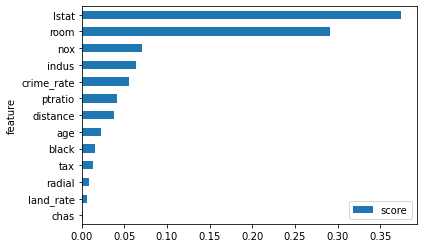

In [125]:
df = pd.DataFrame({
    'feature': features,
    'score': model.featureImportances.values
})

_ = df\
    .sort_values('score')\
    .plot(x='feature', y='score', kind='barh', sort_columns='score')